#**CREATING A BASELINE MODEL**

##CREATING TRAIN,CV AND TEST SPLIT USING TIME BASED SPLITTING

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
!unzip /content/sample_submission.csv.zip

Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [2]:
import pandas as pd
import numpy as np
final_df=pd.read_hdf("/content/gdrive/MyDrive/m5_forecasting_data/final_df.hdf",'mydata')


In [4]:
final_df['event_name']=final_df['event_name_1']+final_df['event_name_2']
final_df['event_type']=final_df['event_type_1']+final_df['event_type_2']

final_df.drop(['event_name_1','event_name_2','event_type_1','event_type_2'],axis=1,inplace=True)

In [5]:
#Product details upto day 1883 is used as training set
X_train = final_df[(final_df['day']>=1200) & (final_df['day']<=1885)]
y_train = X_train['sale']
X_train.drop(['sale'],axis = 1,inplace = True)

#Product details starting from day 1884 and ending with 1912 is used as cross validation set(we will cross validate  our model on 28 days from 1884 to 1912)  
X_cv=final_df[(final_df['day']>=1886) & (final_df['day']<=1913)]
y_cv=X_cv['sale']
X_cv.drop(['sale'],axis=1,inplace=True)
    
#Product details starting from day 1913 is used as test set(we will test our model on 28 days from 1913 to 1941)
#we are testing on 28 days..since our task is to forecast sales for next 28 days
X_test = final_df[(final_df['day']>=1914)]
y_test = X_test['sale']
X_test.drop(['sale'],axis = 1,inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
del final_df


In [7]:
import gc
gc.collect()

100

In [ ]:
X_train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20916140 entries, 36557510 to 57473649
Data columns (total 36 columns):
 #   Column                        Non-Null Count     Dtype  
---  ------                        --------------     -----  
 0   id                            20916140 non-null  int16  
 1   item_id                       20916140 non-null  int16  
 2   dept_id                       20916140 non-null  int8   
 3   cat_id                        20916140 non-null  int8   
 4   store_id                      20916140 non-null  int8   
 5   state_id                      20916140 non-null  int8   
 6   wday                          20916140 non-null  int8   
 7   month                         20916140 non-null  int8   
 8   year                          20916140 non-null  int16  
 9   snap_CA                       20916140 non-null  int8   
 10  snap_TX                       20916140 non-null  int8   
 11  snap_WI                       20916140 non-null  int8   
 12  sell_

In [ ]:
X_train.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'wday',
       'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'day',
       'week_of_year', 'is_weekend', 'is_month_start_or_end',
       'is_first15_day_or_last15_day', 'is_christmas', 'lag_1', 'lag_7',
       'lag_14', 'lag_21', 'lag_28', 'lag_30', 'lag_31', 'rolling_mean_7',
       'rolling_mean_14', 'rolling_mean_28', 'rolling_std_7', 'rolling_std_14',
       'rolling_std_28', 'price_previous_day', 'price_change', 'event_name',
       'event_type'],
      dtype='object')

##CODE FOR SUBMISSION FILE

In [14]:

def generate_submission_file(model,Xval,Xtest,file_name):
    '''
    This function is used to generate a submission file which contains estimated sales for a particular product for next 28 days.
    Parameters:
    1.model: Best trained model
    2.Xval : Input Validation dataset
    3.Xtest: Test dataset
    4.file_name(str): Name of the generated csv file
    '''
    
    yp_val  = model.predict(Xval)
    yp_test  = model.predict(Xtest)
    #Reshaped to (-1,28) shape. -1:the value is inferred from the length of the array and remaining dimensions.
    #Order = 'F':  read / write the elements with the first index changing fastest, and the last index changing slowest.
    yp_val = np.reshape(yp_val, (-1, 28),order = 'F')
    yp_test = np.reshape(yp_test, (-1, 28),order = 'F')
    

    submission = pd.read_csv("sample_submission.csv")
    sub_validation = submission.iloc[:30490,:]
    sub_evaluation = submission.iloc[30490:,:]
    
    F_columns = submission.columns[1:]
    for i in range(len(F_columns)):
        sub_validation[F_columns[i]] = yp_val[:,i]
        sub_evaluation[F_columns[i]] = yp_test[:,i]

    submission = pd.concat([sub_validation,sub_evaluation])
    submission.to_csv(file_name,index = False)
    print("Submission file with name "+file_name+" created successfully")

#IMPLEMENTING LINEAR REGRESSION

In [8]:
col=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'wday',
       'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'day',
       'week_of_year', 'is_weekend', 'is_month_start_or_end',
       'is_first15_day_or_last15_day', 'is_christmas', 'lag_1', 'lag_7',
       'lag_14', 'lag_21', 'lag_28', 'lag_30', 'lag_31', 'rolling_mean_7',
       'rolling_mean_14', 'rolling_mean_28', 'rolling_std_7', 'rolling_std_14',
       'rolling_std_28', 'price_previous_day', 'price_change', 'event_name',
       'event_type']

In [ ]:
from sklearn.linear_model import LinearRegression
reg=LinearRegression(n_jobs=-1)
reg.fit(X_train[col],y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred_cv=reg.predict(X_cv[col])
print("CV RMSE:",np.sqrt(mean_squared_error(y_pred_cv,y_cv)))

y_pred_test=reg.predict(X_test[col])
y_pred_train=reg.predict(X_train[col])

print("TEST RMSE:",np.sqrt(mean_squared_error(y_pred_test,y_test)))
print("TRAIN RMSE:",np.sqrt(mean_squared_error(y_pred_train,y_train)))

CV RMSE: 1.7920643
TEST RMSE: 1.7948849
TRAIN RMSE: 1.850878


In [ ]:
generate_submission_file(reg,reg,X_cv[col],X_test[col],"linear_regression1.csv")

In [ ]:
subm=pd.read_csv("/content/linear_regression1.csv")
subm

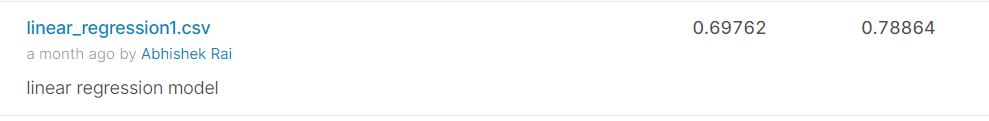

In [ ]:
from IPython.display import Image
Image(filename='/content/lr.JPG') 

#IMPLEMENTING RIDGE REGRESSOR

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
reg=Ridge()
alpha=[0.01, 0.2, 0.1, 1]

for i in alpha:
  reg=Ridge(alpha=i)
  reg.fit(X_train[col],y_train)
  y_pred_cv=reg.predict(X_cv[col])
  score=np.sqrt(mean_squared_error(y_pred_cv,y_cv))
  print(f"For alpha {i} the RMSE is {score} ")
  print('*'*80)
  

For alpha 0.01 the RMSE is 1.7920373678207397 
********************************************************************************
For alpha 0.2 the RMSE is 1.7920398712158203 
********************************************************************************
For alpha 0.1 the RMSE is 1.792038917541504 
********************************************************************************
For alpha 1 the RMSE is 1.7920396327972412 
********************************************************************************


In [ ]:
reg=Ridge(alpha=0.01)
reg.fit(X_train[col],y_train)

y_pred_cv=reg.predict(X_cv[col])
print("CV RMSE:",np.sqrt(mean_squared_error(y_pred_cv,y_cv)))

y_pred_test=reg.predict(X_test[col])
y_pred_train=reg.predict(X_train[col])

print("TEST RMSE:",np.sqrt(mean_squared_error(y_pred_test,y_test)))
print("TRAIN RMSE:",np.sqrt(mean_squared_error(y_pred_train,y_train)))

CV RMSE: 1.7920374
TEST RMSE: 1.7948945
TRAIN RMSE: 1.8508788


In [ ]:
generate_submission_file(reg,X_cv[col],X_test[col],"ridge_regression.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Submission file with name ridge_regression.csv created successfully


In [ ]:
subm=pd.read_csv("ridge_regression.csv")
subm

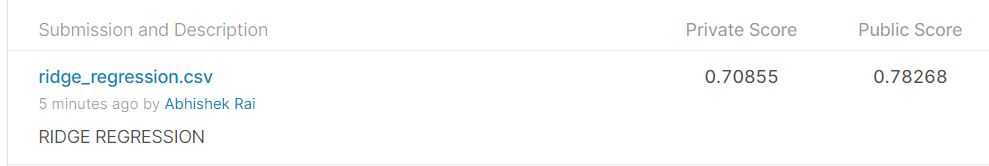

In [ ]:
from IPython.display import Image
Image(filename='/content/RIDGE.JPG') 

#IMPLEMENTING LASSO REGRESSION

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
alpha=[0.01, 0.2, 0.1, 1]

for i in alpha:
  reg=Lasso(alpha=i,max_iter=250)
  reg.fit(X_train[col],y_train)
  y_pred_cv=reg.predict(X_cv[col])
  score=np.sqrt(mean_squared_error(y_pred_cv,y_cv))
  print(f"For alpha {i} the RMSE is {score} ")
  print('*'*80)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2325504.0, tolerance: 27067.890625
  positive)


For alpha 0.01 the RMSE is 1.795409917831421 
********************************************************************************


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37496.0, tolerance: 27067.890625
  positive)


For alpha 0.2 the RMSE is 1.8269041776657104 
********************************************************************************
For alpha 0.1 the RMSE is 1.8203115463256836 
********************************************************************************
For alpha 1 the RMSE is 1.8558831214904785 
********************************************************************************


In [ ]:
reg=Lasso(alpha=0.01,max_iter=250)
reg.fit(X_train[col],y_train)

y_pred_cv=reg.predict(X_cv[col])
print("CV RMSE:",np.sqrt(mean_squared_error(y_pred_cv,y_cv)))

y_pred_test=reg.predict(X_test[col])
y_pred_train=reg.predict(X_train[col])

print("TEST RMSE:",np.sqrt(mean_squared_error(y_pred_test,y_test)))
print("TRAIN RMSE:",np.sqrt(mean_squared_error(y_pred_train,y_train)))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2325504.0, tolerance: 27067.890625
  positive)


CV RMSE: 1.7954099
TEST RMSE: 1.7976841
TRAIN RMSE: 1.8528905


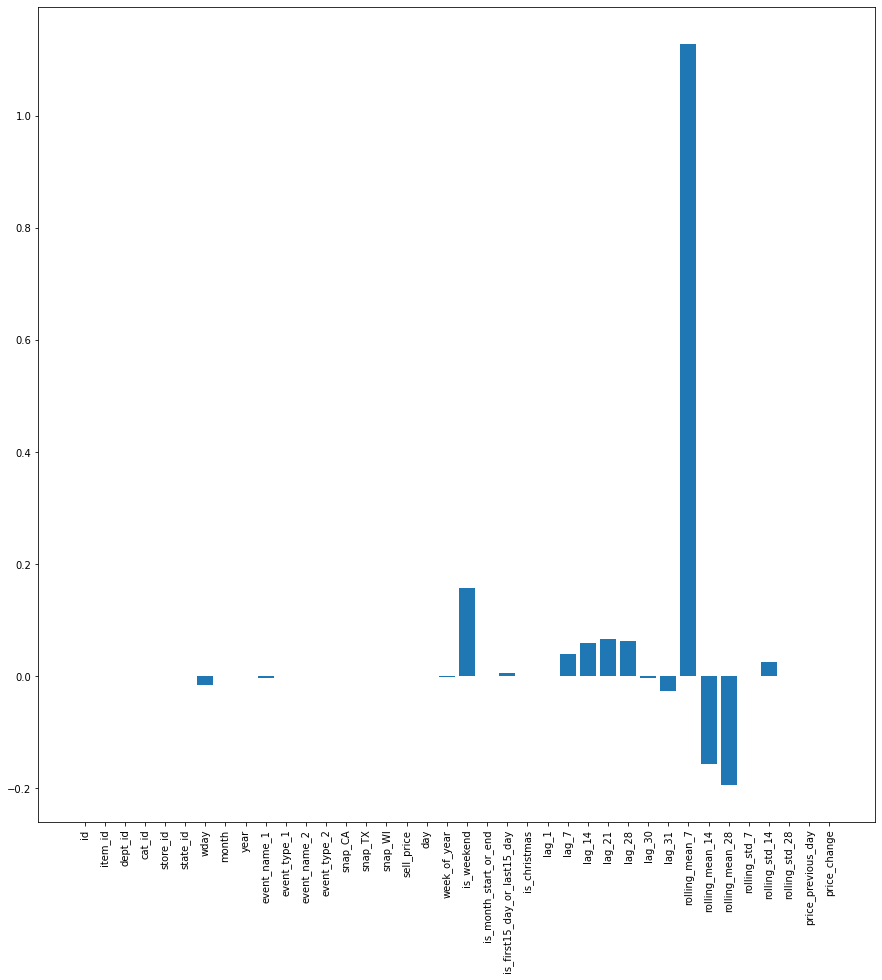

In [ ]:
import matplotlib.pyplot as plt
importance=reg.coef_
feature_important=dict(zip(X_train[col].columns,importance.tolist()))
keys = list(feature_important.keys())
values = list(feature_important.values())

#data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
plt.figure(figsize=(15,15))
plt.bar(x=keys,height=values)
plt.xticks(rotation='vertical')
plt.show()


In [ ]:
generate_submission_file(reg,X_cv[col],X_test[col],"lasso_regression.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Submission file with name lasso_regression.csv created successfully


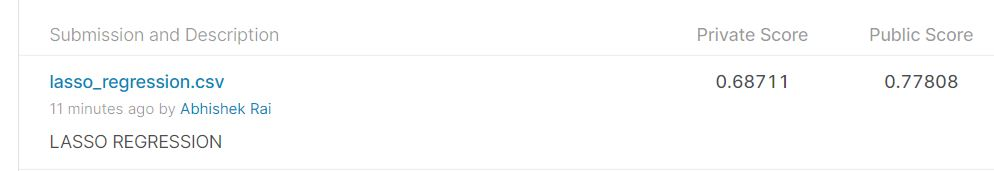

In [ ]:
from IPython.display import Image
Image(filename='/content/LASSO.JPG') 

#ELASTIC NET REGRESSOR

In [ ]:
from sklearn.linear_model import ElasticNet
alpha = [0.01,0.1,1,10]
l1_ratio = [0.01,0.1,1]
for i in alpha:
    for j in l1_ratio:
        model = ElasticNet(alpha=i,l1_ratio=j, max_iter=250)
        model.fit(X_train[col],y_train)
        y_pred = model.predict(X_cv[col])
        score = np.sqrt(mean_squared_error(y_cv,y_pred))
        print(f"For alpha {i} and l1_ratio {j} the RMSE is {score} ")
        print('*'*80)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34621108.0, tolerance: 27067.890625
  positive)


For alpha 0.01 and l1_ratio 0.01 the RMSE is 1.7929389476776123 
********************************************************************************


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24903804.0, tolerance: 27067.890625
  positive)


For alpha 0.01 and l1_ratio 0.1 the RMSE is 1.7931522130966187 
********************************************************************************


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2325504.0, tolerance: 27067.890625
  positive)


For alpha 0.01 and l1_ratio 1 the RMSE is 1.795409917831421 
********************************************************************************


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19401380.0, tolerance: 27067.890625
  positive)


For alpha 0.1 and l1_ratio 0.01 the RMSE is 1.8021425008773804 
********************************************************************************


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1495494.5, tolerance: 27067.890625
  positive)


For alpha 0.1 and l1_ratio 0.1 the RMSE is 1.8041290044784546 
********************************************************************************
For alpha 0.1 and l1_ratio 1 the RMSE is 1.8203115463256836 
********************************************************************************
For alpha 1 and l1_ratio 0.01 the RMSE is 1.84642493724823 
********************************************************************************
For alpha 1 and l1_ratio 0.1 the RMSE is 1.8478697538375854 
********************************************************************************
For alpha 1 and l1_ratio 1 the RMSE is 1.8558831214904785 
********************************************************************************
For alpha 10 and l1_ratio 0.01 the RMSE is 1.9444189071655273 
********************************************************************************
For alpha 10 and l1_ratio 0.1 the RMSE is 2.009639263153076 
********************************************************************************
For a

In [ ]:
reg=ElasticNet(alpha=0.01,l1_ratio=0.01,max_iter=250)
reg.fit(X_train[col],y_train)

y_pred_cv=reg.predict(X_cv[col])
print("CV RMSE:",np.sqrt(mean_squared_error(y_pred_cv,y_cv)))

y_pred_test=reg.predict(X_test[col])
y_pred_train=reg.predict(X_train[col])

print("TEST RMSE:",np.sqrt(mean_squared_error(y_pred_test,y_test)))
print("TRAIN RMSE:",np.sqrt(mean_squared_error(y_pred_train,y_train)))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34621108.0, tolerance: 27067.890625
  positive)


CV RMSE: 1.792939
TEST RMSE: 1.7959634
TRAIN RMSE: 1.8516688


In [ ]:
generate_submission_file(reg,X_cv[col],X_test[col],"ELASTIC_NET.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Submission file with name ELASTIC_NET.csv created successfully


In [ ]:
subm=pd.read_csv("ELASTIC_NET.csv")
subm

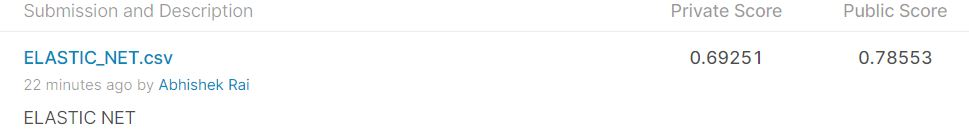

In [ ]:
from IPython.display import Image
Image(filename='/content/ELASTIC.JPG') 

#IMPLEMENTING DECISION TREE REGRESSOR

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

parameters={'max_depth':[2,5,7,10,15,20]}

reg=DecisionTreeRegressor()
hyper=GridSearchCV(reg,parameters,cv=3,scoring='neg_mean_squared_error',verbose=1,return_train_score=True,n_jobs=-1)
hyper.fit(X_train,y_train)#fitting data
hyper.best_estimator_


best_depth_1=hyper.best_params_['max_depth']
bestScore_1=hyper.best_score_


print(" BEST SCORE: ",bestScore_1,"BEST DEPTH: ",best_depth_1) 

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 29.1min finished


 BEST SCORE:  -3.410171007277699 BEST DEPTH:  7


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

reg = DecisionTreeRegressor(max_depth=best_depth_1)
reg.fit(X_train[col], y_train)



DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred_train = reg.predict(X_train[col])
y_score_train= mean_squared_error(y_pred_train, y_train)
print("train rmse:",np.sqrt(y_score_train))

y_pred_cv = reg.predict(X_cv[col])
y_score_cv= mean_squared_error(y_pred_cv, y_cv)
print("CV rmse:",np.sqrt(y_score_cv))

y_pred_test = reg.predict(X_test[col])
y_score_test= mean_squared_error(y_pred_test, y_test)
print("test rmse:",np.sqrt(y_score_test))

train rmse: 1.8172050243876048
CV rmse: 1.7736478110031555
test rmse: 1.7996664234374204


In [ ]:
generate_submission_file(reg,X_cv[col],X_test[col],"Decision_Tree_regressor.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Submission file with name Decision_Tree_regressor.csv created successfully


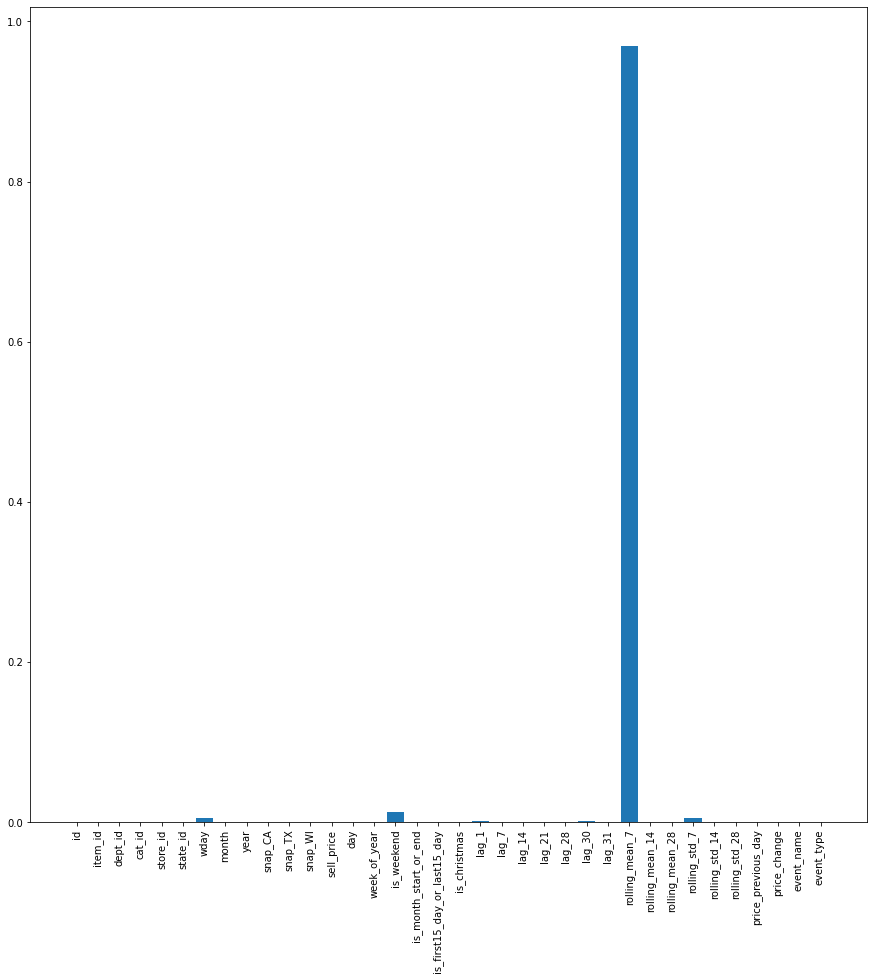

In [ ]:
import matplotlib.pyplot as plt
importance=reg.feature_importances_
feature_important=dict(zip(X_train.columns,importance.tolist()))
keys = list(feature_important.keys())
values = list(feature_important.values())

plt.figure(figsize=(15,15))
plt.bar(x=keys,height=values)
plt.xticks(rotation='vertical')
plt.show()

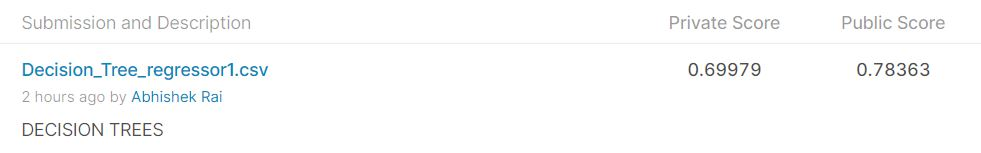

In [ ]:
from IPython.display import Image
Image(filename='/content/decision.JPG') 

#IMPLEMENTING XG BOOST MODEL

In [10]:
#dividing X_train into two parts for applying incremental training
X_train1=X_train.iloc[0:10458070,:]
X_train2=X_train.iloc[10458070:57473650,:]

In [11]:
##dividing y_train into two parts for applying incremental training
y_train1=y_train.iloc[0:10458070]
y_train2=y_train.iloc[10458070:57473650]

In [ ]:
import xgboost as xgb
data1=xgb.DMatrix(X_train1[col],label=y_train1)
data2=xgb.DMatrix(X_train2[col],label=y_train2)

cv_data=xgb.DMatrix(X_cv[col],label=y_cv)
test_data=xgb.DMatrix(X_test[col],label=y_test)


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

learning_rate=[0.001, 0.01, 0.1, 0.2]
n_estimators=[25,50,75,100]#initialising parameters

for i in learning_rate:
  for j in n_estimators:
    param={'learning_rate':i,'n_estimators':j}
    reg1=xgb.train(param,data1)
    file="model"+str(i)+"_"+str(j)+".model"
    reg1.save_model(file)
    reg2=xgb.train(param,data2,xgb_model=file)
    
    y_pred_cv=reg2.predict(cv_data)
    score=np.sqrt(mean_squared_error(y_pred_cv,y_cv))
    print(f"For learning rate {i} and n_estimators {j} the RMSE is {score} ")
    print('*'*80)

[10:04:09] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[10:11:12] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
For learning rate 0.001 and n_estimators 25 the RMSE is 3.6458301544189453 
********************************************************************************
[10:19:01] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[10:25:36] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

param={'learning_rate':0.2,'n_estimators':75}
reg1=xgb.train(param,data1)
file="model.model"
reg1.save_model(file)
xgb_model=xgb.train(param,data2,xgb_model=file)



In [ ]:
from sklearn.externals import joblib
joblib.dump(xgb_model,'XGB_model.pkl')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
y_pred_train1 = xgb_model.predict(data1)
y_score_train1= mean_squared_error(y_pred_train1, y_train1)
y_pred_train2 = xgb_model.predict(data2)
y_score_train2= mean_squared_error(y_pred_train2, y_train2)
print("TRAIN rmse:",np.sqrt((y_score_train1+y_score_train2))/2)


y_pred_cv = xgb_model.predict(cv_data)
y_score_cv= mean_squared_error(y_pred_cv, y_cv)
print("CV rmse:",np.sqrt(y_score_cv))

y_pred_test = xgb_model.predict(test_data)
y_score_test= mean_squared_error(y_pred_test, y_test)
print("TEST rmse:",np.sqrt(y_score_test))

TRAIN rmse: 1.3339394330978394
CV rmse: 1.8093596
TEST rmse: 1.8427035


In [ ]:
xgb_model=joblib.load("/content/XGB_model.pkl")

In [ ]:
generate_submission_file(xgb_model,X_cv,X_test,"Xgboost.csv")

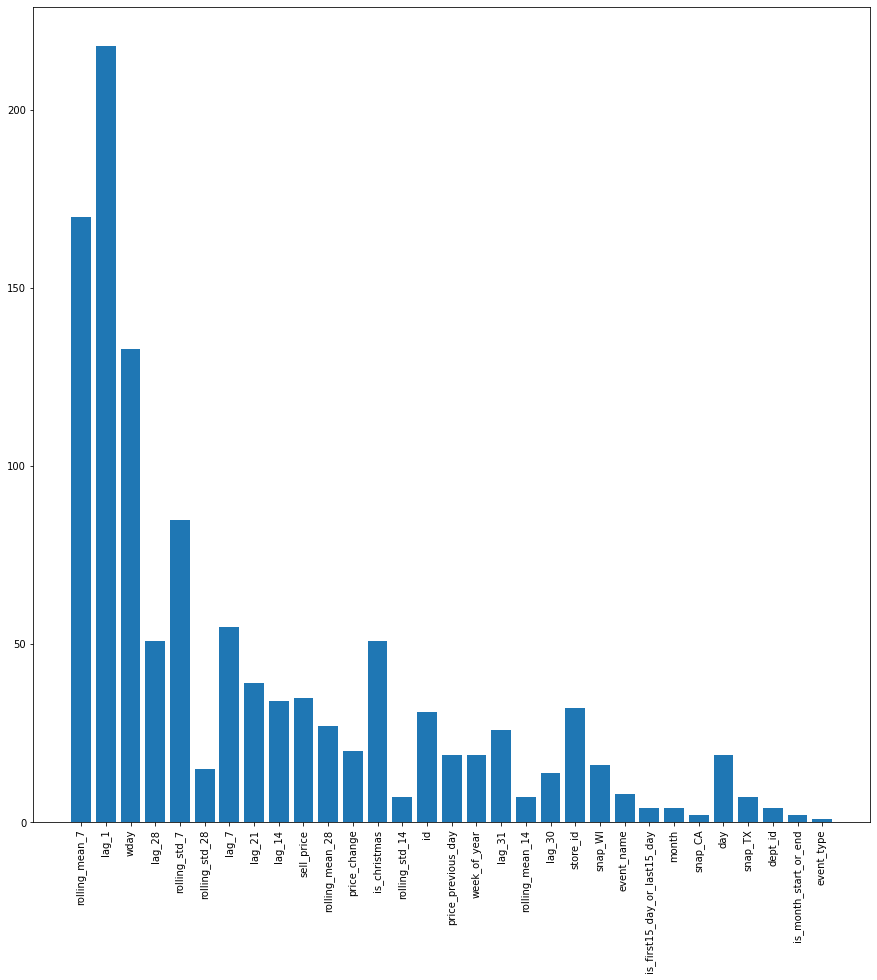

In [ ]:
import matplotlib.pyplot as plt
feature_important = xgb_model.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

plt.figure(figsize=(15,15))
plt.bar(x=keys,height=values)
plt.xticks(rotation='vertical')
plt.show()

#IMPLEMENTING LIGHTGB MODEL

In [12]:
import lightgbm as lgb
data1=lgb.Dataset(X_train1[col],label=y_train1,free_raw_data=False)
data2=lgb.Dataset(X_train2[col],label=y_train2,free_raw_data=False)

cv_data=lgb.Dataset(X_cv[col],label=y_cv)
test_data=lgb.Dataset(X_test[col],label=y_test)

In [ ]:
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error


learning_rate=[ 0.05,0.03,0.01, 0.1, 0.2]
n_estimators=[50,75,100,250]#initialising parameters

for i in learning_rate:
  for j in n_estimators:
    param={'learning_rate':i,'n_estimators':j}
    reg1=lgb.train(param,data1)
    
    file="model1"+str(i)+"_"+str(j)+".model"
    reg1.save_model(file)
    reg2=lgb.train(param,data2,init_model=file)
    
    
    y_pred_cv=reg2.predict(X_cv)
    score=np.sqrt(mean_squared_error(y_pred_cv,y_cv))
    print(f"For learning rate {i} and n_estimators {j} the RMSE is {score} ")
    print('*'*80)


In [13]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
param={'learning_rate':0.05,'n_estimators':100}

reg1=lgb.train(param,data1)
file="model1.model"
reg1.save_model(file)
lgb_model=lgb.train(param,data2,init_model=file)

y_train_pred = lgb_model.predict(X_train[col])
y_score_train = mean_squared_error(y_train_pred, y_train)
print("train rmse:",np.sqrt(y_score_train))

y_cv_pred = lgb_model.predict(X_cv[col])
y_score_cv = mean_squared_error(y_cv_pred, y_cv)
print("CV rmse:",np.sqrt(y_score_cv))


y_test_pred = lgb_model.predict(X_test[col])
y_score_test = mean_squared_error(y_test_pred, y_test)
print("test rmse:",np.sqrt(y_score_test))

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


train rmse: 1.7283635108038997
CV rmse: 1.7463282236434132
test rmse: 1.755325015553907


In [15]:
generate_submission_file(lgb_model,X_cv[col],X_test[col],"lgbm1.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Submission file with name lgbm1.csv created successfully


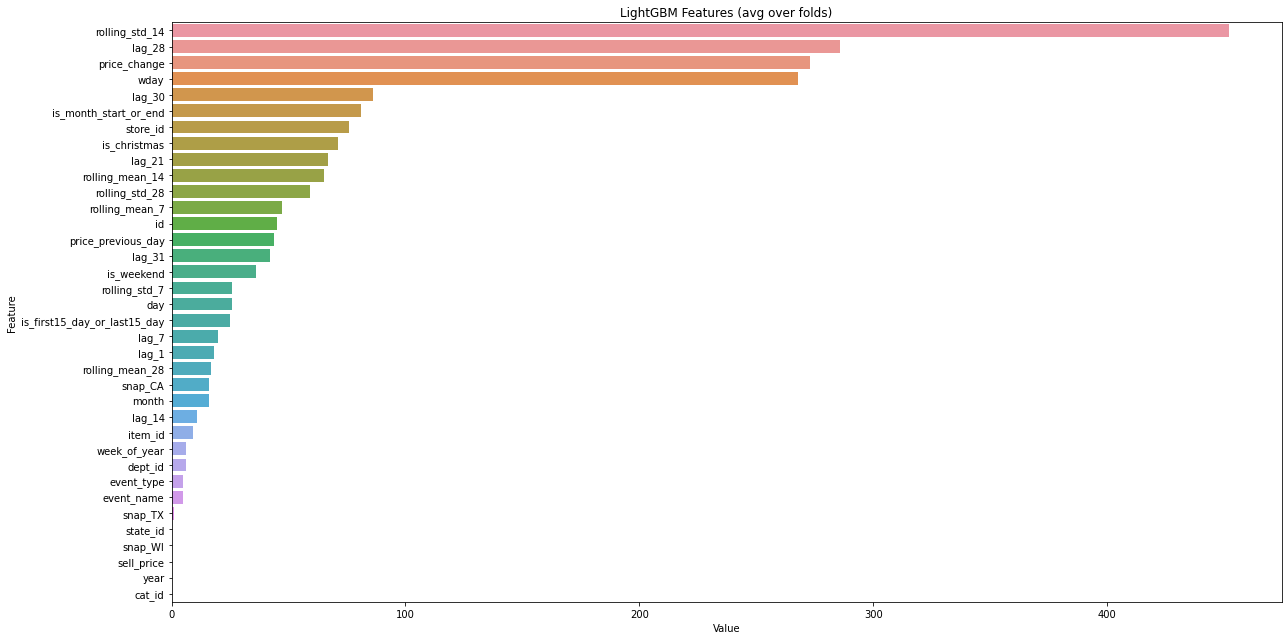

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
xg=joblib.load("model.pkl")

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(xg.feature_importance(),X_train[col].columns)), columns=['Value','Feature'])

plt.figure(figsize=(18, 9))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import Image
Image(filename='lgbm.JPG') 

##IMPLEMENTING CATBOOST MODEL

In [16]:
!pip3 install catboost



     |████████████████████████████████| 69.2 MB 5.5 kB/s 


In [17]:
import catboost as cb
from sklearn.metrics import mean_squared_error

model = cb.CatBoostRegressor(loss_function='RMSE')
model.fit(X_train,y_train)

Learning rate set to 0.229322
0:	learn: 3.0687635	total: 1.83s	remaining: 30m 29s
1:	learn: 2.6832563	total: 3.57s	remaining: 29m 43s
2:	learn: 2.4086685	total: 5.15s	remaining: 28m 32s
3:	learn: 2.2199961	total: 6.61s	remaining: 27m 26s
4:	learn: 2.0896796	total: 8.35s	remaining: 27m 42s
5:	learn: 2.0005761	total: 10s	remaining: 27m 41s
6:	learn: 1.9423436	total: 11.8s	remaining: 27m 56s
7:	learn: 1.9043295	total: 13.4s	remaining: 27m 38s
8:	learn: 1.8795976	total: 14.9s	remaining: 27m 18s
9:	learn: 1.8625768	total: 16.4s	remaining: 27m 2s
10:	learn: 1.8503608	total: 18s	remaining: 26m 58s
11:	learn: 1.8419296	total: 19.5s	remaining: 26m 46s
12:	learn: 1.8352669	total: 21.2s	remaining: 26m 50s
13:	learn: 1.8301630	total: 23s	remaining: 26m 57s
14:	learn: 1.8254499	total: 24.5s	remaining: 26m 48s
15:	learn: 1.8227268	total: 25.9s	remaining: 26m 35s
16:	learn: 1.8198307	total: 27.4s	remaining: 26m 24s
17:	learn: 1.8173967	total: 28.9s	remaining: 26m 16s
18:	learn: 1.8147652	total: 30.8s

In [18]:
import numpy as np
pred = model.predict(X_cv)
rmse = (np.sqrt(mean_squared_error(y_cv, pred)))
print("CV rmse:",rmse)

pred_test = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred_test)))
print("TEST rmse:",rmse)


CV rmse: 1.7550030464972113
TEST rmse: 1.7610096297235083


In [19]:
pred_train = model.predict(X_train)
rmse_train = (np.sqrt(mean_squared_error(y_train, pred_train)))

print("TRAIN rmse:",rmse_train)


TRAIN rmse: 1.603935114635707


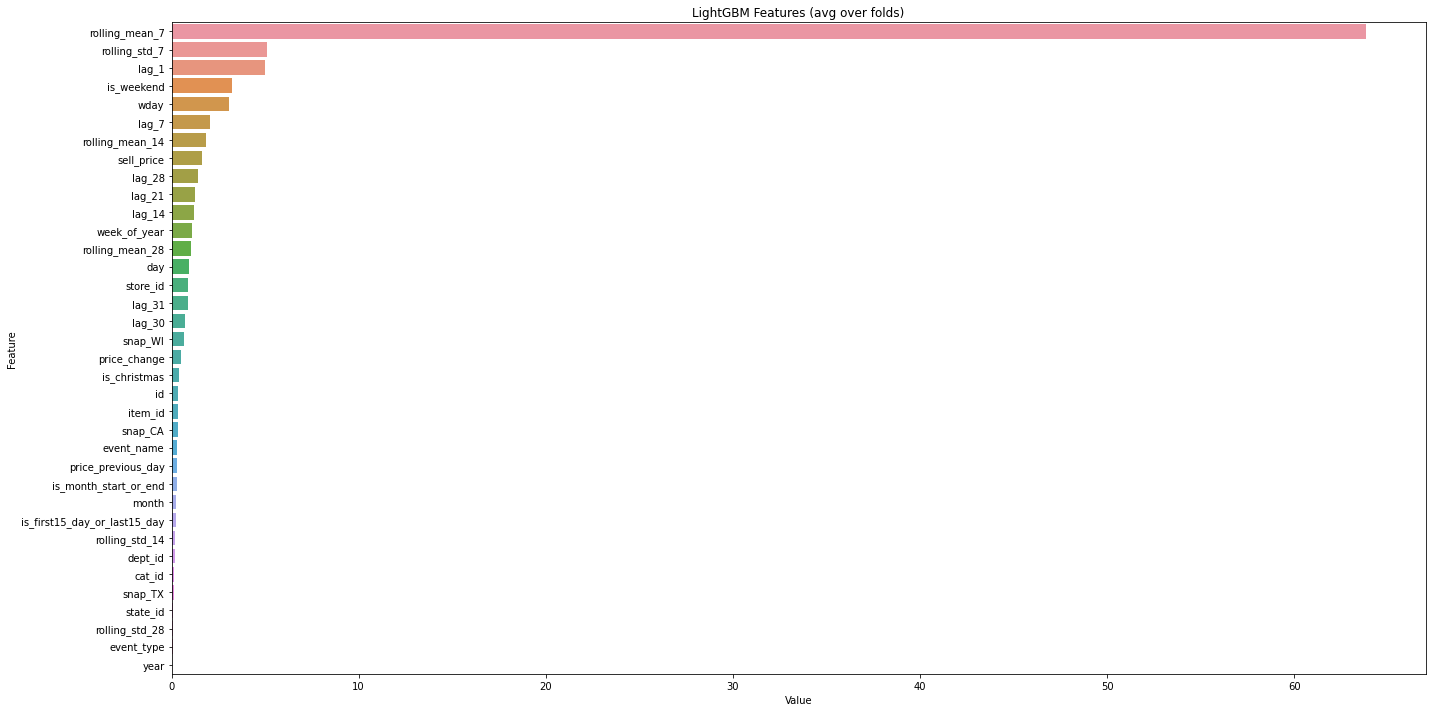

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train[col].columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [22]:
generate_submission_file(model,X_cv,X_test,"catboost.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Submission file with name catboost.csv created successfully


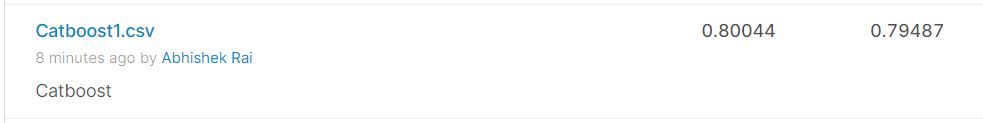

In [25]:
from IPython.display import Image
Image(filename='/content/Capture.JPG')

In [37]:
#https://www.geeksforgeeks.org/creating-tables-with-prettytable-library-python/
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["MODEL", "PRIVATE WRMSSE","PUBLIC WRMSSE"])
myTable.title = "PERFORMANCE ON DATA OF 2 YEARS"



# Add rows
myTable.add_row(["LINEAR REGRESSION",'0.68762','0.78864'])
myTable.add_row(["RIDGE REGRESSION", '0.68711','0.77808'])
myTable.add_row(["ELASTIC NET REGRESSION",'0.69251','0.78553'])
myTable.add_row(["DECISION TREE REGRESSOR", '0.69979','0.78363'])
myTable.add_row(["LIGHTGBM",'0.66999','0.71980' ])
myTable.add_row(["CATBOOST",'0.80044','0.79487' ])
print(myTable)

+----------------------------------------------------------+
|              PERFORMANCE ON DATA OF 2 YEARS              |
+-------------------------+----------------+---------------+
|          MODEL          | PRIVATE WRMSSE | PUBLIC WRMSSE |
+-------------------------+----------------+---------------+
|    LINEAR REGRESSION    |    0.68762     |    0.78864    |
|     RIDGE REGRESSION    |    0.68711     |    0.77808    |
|  ELASTIC NET REGRESSION |    0.69251     |    0.78553    |
| DECISION TREE REGRESSOR |    0.69979     |    0.78363    |
|         LIGHTGBM        |    0.66999     |    0.71980    |
|         CATBOOST        |    0.80044     |    0.79487    |
+-------------------------+----------------+---------------+


#CUSTOM MODEL

In [26]:
import pandas as pd
import numpy as np
final_df=pd.read_hdf("/content/gdrive/MyDrive/m5_forecasting_data/final_df.hdf",'mydata')


In [27]:
final_df=final_df[final_df['day']>=1200]

In [28]:
y=final_df['sale']
final_df=final_df.drop(['sale'],axis=1)

In [29]:
from sklearn.model_selection import train_test_split
#splitting into train and test set
X_train,X_test,y_train,y_test=train_test_split(final_df,y,test_size=0.2,random_state=42)

#splitting training set into two sets 
d1_train,d2_train,d1_test,d2_test=train_test_split(X_train,y_train,test_size=0.5,random_state=42)





In [30]:
import gc
del final_df
del X_train
del y_train
gc.collect()

318

In [31]:
#creating samples form dataset
import numpy as np
n=200000 #number of datapoints in each sample
def create_samples(x,y,k,n):
  x_sample=[]
  y_sample=[]
  for i in range(k):
    random_index=np.random.randint(0,x.shape[0],n)#selecting random index from dataframe
    x_sample1=x.iloc[random_index]#selecting samples from the randomly generated indeices
    y_sample1=y.iloc[random_index]
    #appending the generated samples to the list.
    x_sample.append(x_sample1)
    y_sample.append(y_sample1)
  return x_sample,y_sample



In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
#!pip3 install catboost
#import catboost as cb
import xgboost as xgb
import lightgbm as lgb
def base_models(x_sample,y_sample):
  models_list=[]
  for i in range(len(x_sample)):
    rndm_number=np.random.randint(0,4)
    if rndm_number==0:
      #train linear regression model
      model=LinearRegression(n_jobs=-1)
      model.fit(x_sample[i],y_sample[i])
      models_list.append(model)
    elif rndm_number==1:
      #train decision tree model
      model=DecisionTreeRegressor()
      model.fit(x_sample[i],y_sample[i])
      models_list.append(model)
    elif rndm_number==2:
      #train ridge regressor model
      model=xgb.XGBRegressor(n_jobs=-1)
      model.fit(x_sample[i],y_sample[i])
      models_list.append(model)
    elif rndm_number==3:
      #train lgbm model
      model=lgb.LGBMRegressor(n_jobs=-1)
      model.fit(x_sample[i],y_sample[i])
      models_list.append(model)

  return models_list




In [33]:
def predictions_from_d2(models_list,d2_train):
  pred={}
  for i in range(len(models_list)):
    key="model"+str(i)
    pred[key]=models_list[i].predict(d2_train)
    

  return pd.DataFrame(pred)


In [ ]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
k=[5,10,15,20,30,40]
rmse=[]
for i in tqdm(k):
  x_samples,y_samples=create_samples(d1_train,d1_test,i,n)
  model_list=base_models(x_samples,y_samples)
  pred_df=predictions_from_d2(model_list,d2_train)
  #using linear regression as metamodel
  m_model=LinearRegression(n_jobs=-1)
  m_model.fit(pred_df,d2_test)
  pred_meta_model_on_test=predictions_from_d2(model_list,X_test)
  y_test_pred = m_model.predict(pred_meta_model_on_test)
  
  rmse.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
  print(rmse)
  


  0%|          | 0/6 [00:00<?, ?it/s]

[08:27:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 17%|█▋        | 1/6 [01:12<06:02, 72.54s/it]

[1.7986927421318684]
[08:29:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 33%|███▎      | 2/6 [03:57<06:41, 100.31s/it]

[1.7986927421318684, 1.7842268568119393]
[08:31:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 50%|█████     | 3/6 [07:37<06:48, 136.05s/it]

[1.7986927421318684, 1.7842268568119393, 1.7890270559646737]
[08:35:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:35:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:35:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:36:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:36:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:36:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 67%|██████▋   | 4/6 [13:40<06:48, 204.39s/it]

[1.7986927421318684, 1.7842268568119393, 1.7890270559646737, 1.7799139358092722]
[08:41:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:41:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:42:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:42:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:42:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 83%|████████▎ | 5/6 [20:36<04:27, 267.87s/it]

[1.7986927421318684, 1.7842268568119393, 1.7890270559646737, 1.7799139358092722, 1.7763206966429501]
[08:48:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:50:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:50:32]

100%|██████████| 6/6 [32:31<00:00, 325.18s/it]

[1.7986927421318684, 1.7842268568119393, 1.7890270559646737, 1.7799139358092722, 1.7763206966429501, 1.7719639326797405]


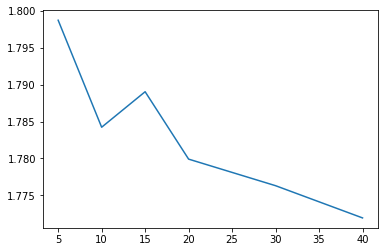

In [ ]:
import matplotlib.pyplot as plt
plt.plot(k,rmse)
plt.show()

#THE OPTIMAL BASE LEARNER IS COMING OUT TO BE 40

In [34]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

rmse=[]

x_samples,y_samples=create_samples(d1_train,d1_test,40,n)
model_list=base_models(x_samples,y_samples)
pred_df=predictions_from_d2(model_list,d2_train)
#using linear regression as metamodel
m_model=LinearRegression(n_jobs=-1)
m_model.fit(pred_df,d2_test)
pred_meta_model_on_test=predictions_from_d2(model_list,X_test)
y_test_pred = m_model.predict(pred_meta_model_on_test)
  
rmse.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
print(rmse)

[10:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:44:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:44:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:44:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:44:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

##THE TEST RMSE USING STACKING REGRESSOR IS 1.77